In [1]:
#%% Imports
import os
import numpy as np
#import spectral
import matplotlib.pyplot as plt
import skimage.io
#import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

import annotation, image_render, hyspec_io

In [2]:
# Paths
json_gray = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
annotation_png = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/OlbergAreaS/OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.png'
hyspec_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC/OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr'

In [3]:
# Read annotation
class_dict = annotation.read_hasty_metadata(json_gray)

In [4]:
# Show classes and indices
for class_name,class_ind in class_dict.items():
    print(class_name + ': ' + str(class_ind))

Sand: 1
Gravel: 2
Mud: 3
Terrestrial: 4
Zostera marina - dominant: 5
Zostera marina - normal: 6
Zostera marina - sparse: 7
Zostera marina with turf algae: 8
Turf algae - dominant: 9
Turf algae - normal: 10
Turf algae - sparse: 11
Rockweed: 12
Rockweed with turf algae: 13
Fucus serratus: 14
Aegagropila (algae ball): 15
Mixed algae classes on soft substrate: 16
Saccharina latissima: 17


In [5]:
# Load hyperspectral file
(im_cube,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(hyspec_file)

In [6]:
# Create mask indicating non-zero data
nonzero_mask = ~np.all(im_cube == 0,axis=2)

In [7]:
# Load PNG file
annotation_mask = skimage.io.imread(annotation_png) * nonzero_mask

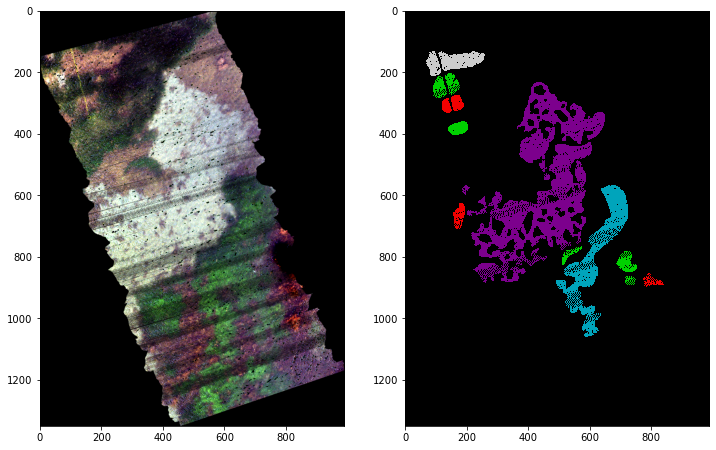

In [8]:
# Show image and annotation mask
fig,ax = plt.subplots(ncols=2,figsize=(12,12))
ax[0].imshow(image_render.percentile_stretch(im_cube[:,:,rgb_ind]))
ax[1].imshow(annotation_mask,interpolation='none',cmap='nipy_spectral')

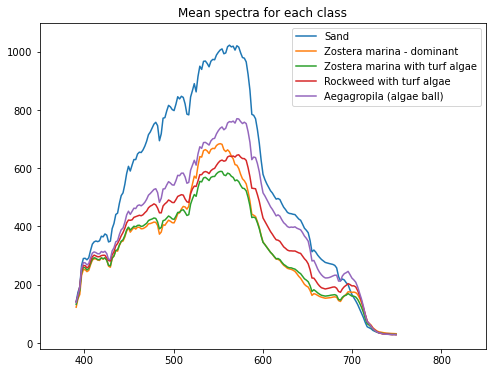

In [9]:
# Extract annotated spectra, show mean, and log which classes are visible (non-zero)
fig,ax = plt.subplots(ncols=1,figsize=(8,6))
visible_classes = {}
extracted_spectra = np.empty((0,im_cube.shape[2]))
label_vector = np.empty((0,1),dtype=int)

for (class_name,class_ind) in class_dict.items():
    spec = im_cube[annotation_mask == class_ind]
    if len(spec) > 0:
        plt.plot(wl,spec.mean(axis=0),label=class_name)
        visible_classes[class_name] = class_ind
        extracted_spectra = np.append(extracted_spectra,spec,axis=0)
        label_vector = np.append(label_vector, class_ind*np.ones(spec.shape[0]))
        
plt.legend()
plt.ylim(-20,1100)
plt.xlim(350,850)
plt.title('Mean spectra for each class')
plt.draw()

In [10]:
label_vector.shape

(139860,)

In [11]:
extracted_spectra.shape

(139860, 173)

In [12]:
#%% Create pipeline for feature normalization, PCA and classification
clf = make_pipeline(StandardScaler(),PCA(n_components=8), RandomForestClassifier(n_estimators=20)) 

In [13]:
#%% Train the classifier pipeline
clf.fit(extracted_spectra, label_vector)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=20))])

Note that the classifier is trained on all the annotated spectra, which means that the classes are imbalanced. It should be possible to extract only a small subset of the annotated pixels and train the classifier on these. This could also enable better balancing of the classes.

In [14]:
#%% Apply model to all pixels in image
X_im = np.reshape(im_cube,(-1,im_cube.shape[2]))
im_classified = np.reshape(clf.predict(X_im),(im_cube.shape[0],im_cube.shape[1]))

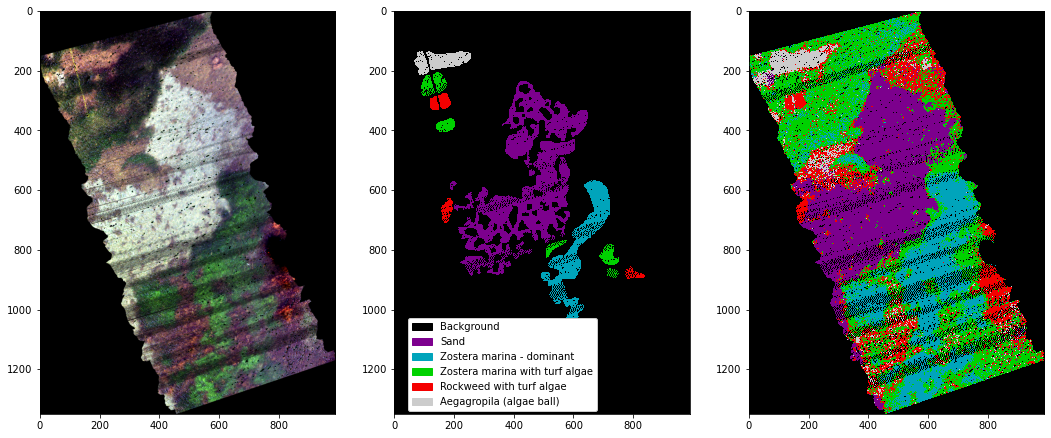

In [15]:
fig,ax = plt.subplots(ncols=3,figsize=(18,12))
ax[0].imshow(image_render.percentile_stretch(im_cube[:,:,rgb_ind]))
cl_im = ax[1].imshow(annotation_mask,interpolation='none',cmap='nipy_spectral')

# Create classification plot legend
import matplotlib.patches as mpatches
values = list(visible_classes.values())
values.insert(0,0)
class_name = list(visible_classes.keys())
class_name.insert(0,'Background')
colors = [cl_im.cmap(cl_im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=class_name[i] ) for i in range(len(values)) ]
ax[1].legend(handles=patches, bbox_to_anchor=(0.03, 0.25), loc=2, framealpha=1 )

ax[2].imshow(im_classified*nonzero_mask,interpolation='none',cmap='nipy_spectral')